<a href="https://colab.research.google.com/github/zelda2333/LITS-Unet/blob/master/nii%E6%A0%BC%E5%BC%8F%E5%9B%BE%E7%89%87%E8%AF%BB%E5%8F%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import skimage
def show_img(ori_img):
    skimage.io.imshow(ori_img, cmap = 'gray')
    skimage.io.show()

C:\Users\River\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


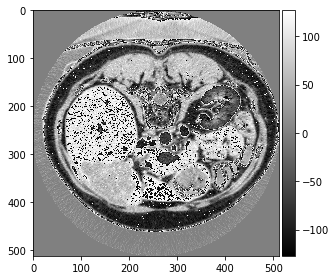

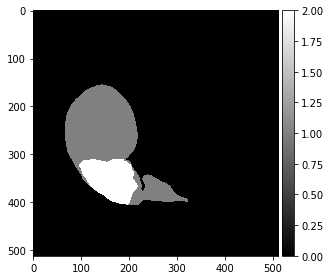

In [0]:
import os
import numpy as np

import h5py
import SimpleITK as sitk

ct_dir = "..//Ct//volume-28.nii"
ct_seg_dir = "..//Segmentation//segmentation-28.nii"

ct = sitk.ReadImage(ct_dir, sitk.sitkInt8)
ct_seg = sitk.ReadImage(ct_seg_dir, sitk.sitkInt8)

ct_array = sitk.GetArrayFromImage(ct)
ct_array_seg = sitk.GetArrayFromImage(ct_seg)

### 原始图片
show_img(ct_array[65])
show_img(ct_array_seg[65])

In [0]:
# -*- coding: utf-8 -*-
import h5py
import os

class HDF5DatasetWriter:
    def __init__(self, image_dims, mask_dims, outputPath, bufSize=200):
        """
        Args:
        - bufSize: 当内存储存了bufSize个数据时，就需要flush到外存
        """
        if os.path.exists(outputPath):
            raise ValueError("The supplied 'outputPath' already"
                             "exists and cannot be overwritten. Manually delete"
                             "the file before continuing", outputPath)
        
        self.db = h5py.File(outputPath, "w")
        # 创建名为images的dataset
        self.data = self.db.create_dataset("images", image_dims, maxshape=(None,)+image_dims[1:], dtype="float")
        self.masks = self.db.create_dataset("masks", mask_dims, maxshape=(None,)+mask_dims[1:], dtype="int")
        self.dims = image_dims
        # bufSize 的作用是当内存达到一定程度时，将数据Flush到外存中
        self.bufSize = bufSize
        self.buffer = {"data": [], "masks": []}
        # idx属性表示当前存储的图片数量，最开始为0
        self.idx = 0
    

    def add(self, rows, masks):
        # extend() 函数用于在列表末尾一次性追加另一个序列中的多个值（用新列表扩展原来的列表)
        # 注意，用extend还有好处，添加的数据不会是之前list的引用！！
        self.buffer["data"].extend(rows)
        self.buffer["masks"].extend(masks)
#         print("len ",len(self.buffer["data"]))
        
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()
    
    def flush(self):
        i = self.idx + len(self.buffer["data"])
        if i>self.data.shape[0]:
            # 扩展大小的策略可以自定义，这里乘以2表示直接在原来的基础上扩大一倍
            new_shape = (self.data.shape[0]*2,)+self.dims[1:]
            print("resize to new_shape:",new_shape)
            self.data.resize(new_shape)
            self.masks.resize(new_shape)
        self.data[self.idx:i,:,:,:] = self.buffer["data"]
        self.masks[self.idx:i,:,:,:] = self.buffer["masks"]
        print("h5py have writen %d data"%i)
        self.idx = i
        self.buffer = {"data": [], "masks": []}
        
    
    def close(self):
        if len(self.buffer["data"]) > 0:
            self.flush()

#### 这是直接写入，没有使用上面的HDF5writer工具类

In [0]:
import os
import numpy as np

import h5py
import SimpleITK as sitk

# 存储的nii文件夹路径
ct_dir = "..//Ct//volume-28.nii"
ct_seg_dir = "..//Segmentation//segmentation-28.nii"

ct = sitk.ReadImage(ct_dir, sitk.sitkInt8)
ct_seg = sitk.ReadImage(ct_seg_dir, sitk.sitkInt8)

ct_array = sitk.GetArrayFromImage(ct)
ct_array_seg = sitk.GetArrayFromImage(ct_seg)

images = ct_array[:, :, :, np.newaxis]
masks = ct_array_seg[:, :, :, np.newaxis]

print(images.shape)
print(masks.shape)

h5 = h5py.File("./demo.h5", 'w')
h5.create_dataset("images", data=images)
h5.create_dataset("masks", data=masks)

(129, 512, 512, 1)
(129, 512, 512, 1)


<HDF5 dataset "masks": shape (129, 512, 512, 1), type "|i1">

In [0]:
h5

<HDF5 file "demo.h5" (mode r+)>

In [0]:
h5['images'].shape

(129, 512, 512, 1)

In [0]:
image = h5['images'][100]
mask = h5['masks'][100]

In [0]:
image = image.reshape((512,512))
mask = mask.reshape((512,512))

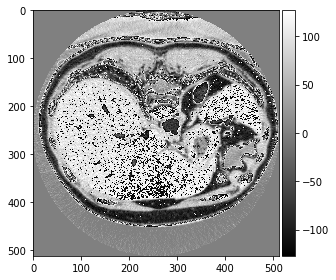

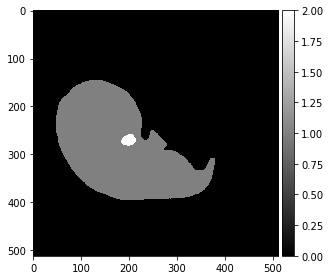

In [0]:
show_img(image)
show_img(mask)

In [0]:
import skimage
def show_img(ori_img):
    skimage.io.imshow(ori_img, cmap = 'gray')
    skimage.io.show()

#### 使用HDF5Writer工具类

In [0]:
import SimpleITK as sitk
import os
import numpy as np

images = []
masks = []

# 存储的nii 文件夹路径
ct_dir = "..//Ct"
ct_seg_dir = "..//Segmentation"

# 初始化HDF5数据对象
# 设置原始dataset的shape大小，第一维的100表示原始能够存储100张图片
image_dims = (100, 512, 512, 1)
mask_dims = (100, 512, 512, 1)

# 实例HDF5对象
h5 = HDF5DatasetWriter(image_dims, mask_dims, './ct_nii.h5')

# 列出ct文件夹下的所有文件，并且按照文件名序号排序
ct_filenames = os.listdir(ct_dir)
ct_filenames.sort()

ct_seg_filenames = os.listdir(ct_seg_dir)
ct_seg_filenames.sort()

for idx in range(len(ct_filenames)):
    ct = sitk.ReadImage(os.path.join(ct_dir, ct_filenames[idx]), sitk.sitkInt8)
    ct_array = sitk.GetArrayFromImage(ct)
    
    ct_seg = sitk.ReadImage(os.path.join(ct_seg_dir, ct_seg_filenames[idx]), sitk.sitkFloat32)
    ct_seg_array = sitk.GetArrayFromImage(ct_seg)
    for i in range(len(ct_array)):
        image = ct_array[i][np.newaxis, :, :, np.newaxis]
#             images.extend(image)

        image_seg = ct_seg_array[i][np.newaxis, :, :, np.newaxis]
#             masks.append(image_seg)
        h5.add(image, image_seg)
h5.close()

C:\Users\River\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


resize to new_shape: (200, 512, 512, 1)
h5py have writen 129 data


In [0]:
ct_array[0].shape

(512, 512)

In [0]:
### 写入成功后，读取其中一张图片并展示
import skimage
import h5py

def show_img(ori_img):
    skimage.io.imshow(ori_img, cmap = 'gray')
    skimage.io.show()

# 读取h5py文件
data = h5py.File('./ct_nii.h5', 'r')
# 访问的方式类似于字典，通过key来访问值
# 查看 images dataset的大小
data['images'].shape

# 如果想要知道h5py文件中有多少张图片，访问idx属性
h5.idx

# 取其中一张照片的话，直接下标访问即可
# 取出images中的第61张照片，shape大小为 (512, 512, 1)
image = data['images'][60]

# reshape操作，使得大小为 (512, 512)
image = image.reshape((512, 512))

# 显示照片
show_img(image)

(200, 512, 512, 1)

129

In [0]:
image = data['images'][68]

In [0]:
image.shape

(512, 512, 1)

In [0]:
image = image.reshape((512, 512))

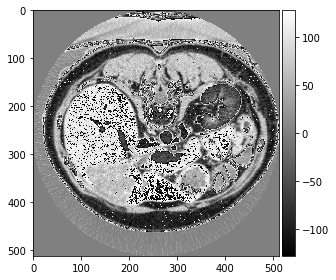

In [0]:
show_img(image)